## Put Call Parity: Synthetic Positions for Building Protected Investment Strategies

#### Import AAPL data and Options Chains

In [36]:
library(quantmod)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(ggpattern)

In [37]:
# Focus on Apple ('AAPL')
stock <- "AAPL"

# Current Apple options chain for realistic pricing
current_options <- getOptionChain(stock)

# Historical Apple stock prices for "what if" scenarios  
getSymbols(stock, from = Sys.Date() - 365, to = Sys.Date())
historical_prices <- AAPL

# Extract monthly endpoints with their actual dates
monthly_endpoints <- endpoints(AAPL, on = "months")
monthly_data <- AAPL[monthly_endpoints]

[1] "AAPL"

In [38]:
# Get current Apple stock price
current_price <- as.numeric(last(Cl(AAPL)))
print(paste("Current AAPL price:", round(current_price, 2)))

[1] "Current AAPL price: 230.89"


In [39]:
# Extract specific strike data
# Assume a strike price of $230
strike_230_call <- current_options$calls[current_options$calls$Strike == 230, "Last"]
strike_230_put <- current_options$puts[current_options$puts$Strike == 230, "Last"]

print(paste("230 Strike Call Price:", strike_230_call))
print(paste("230 Strike Put Price:", strike_230_put))

[1] "230 Strike Call Price: 2.61"
[1] "230 Strike Put Price: 2.24"


## Data Setup

In [40]:
# Market data from Apple options chain
current_stock_price <- current_price
strike_price <- 230 #Hypothetical for this exercise
call_price <- strike_230_call
put_price <- strike_230_put
shares <- 100  # Standard option contract size
call_premium <- strike_230_call * shares
put_premium <- put_price * shares

In [41]:
# Create range of stock prices at expiration for analysis
stock_prices_at_exp <- seq(200, 260, by = 2)

In [42]:
# Calculate payoffs for each strategy
payoff_data <- data.frame(
  stock_price = stock_prices_at_exp
  ) %>%
    mutate(
      # Pure stock position (no protection)
      pure_stock_profit = (stock_price - current_stock_price) * shares,
      
      # Portfolio A: Protected Stock (Stock + Put)
      stock_value = stock_price * shares,
      put_payoff = pmax(strike_price - stock_price, 0) * shares,  # Put intrinsic value
      portfolio_a_total = stock_value + put_payoff,
      portfolio_a_profit = portfolio_a_total - (current_stock_price * shares + put_price * shares),
      
      # Portfolio B: Synthetic Stock (Call + T-Bills)
      call_payoff = pmax(stock_price - strike_price, 0) * shares,  # Call intrinsic value
      tbill_value = strike_price * shares,  # Simplified: ignore small interest for clarity
      portfolio_b_total = call_payoff + tbill_value,
      portfolio_b_profit = portfolio_b_total - (call_price * shares + strike_price * shares)
    )

In [43]:
data_head <- head(payoff_data, 3)
data_head

,stock_price,pure_stock_profit,stock_value,put_payoff,portfolio_a_total,portfolio_a_profit,call_payoff,tbill_value,portfolio_b_total,portfolio_b_profit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200,-3089,20000,3000,23000,-312.9999,0,23000,23000,-261
2,202,-2889,20200,2800,23000,-312.9999,0,23000,23000,-261
3,204,-2689,20400,2600,23000,-312.9999,0,23000,23000,-261


In [44]:
data_tail <- tail(payoff_data, 3)
data_tail

,stock_price,pure_stock_profit,stock_value,put_payoff,portfolio_a_total,portfolio_a_profit,call_payoff,tbill_value,portfolio_b_total,portfolio_b_profit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29,256,2511,25600,0,25600,2287,2600,23000,25600,2339
30,258,2711,25800,0,25800,2487,2800,23000,25800,2539
31,260,2911,26000,0,26000,2687,3000,23000,26000,2739


## Payoff Diagram

In [45]:
# Before creating the plot
options(repr.plot.width = 8, repr.plot.height = 5)

theme <-
theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 17, face= "bold", color = "gray40", hjust=0.5),
    panel.background = element_rect(fill = "white", color = NA),
    plot.background = element_rect(fill = "white", color = NA),
    legend.position = "bottom",
    legend.title = element_text(size=15, face = "bold"),
    legend.text = element_text(size = 15),
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 14, color = "gray50", hjust = 0),
    axis.title.x = element_text(size = 15, face="bold"),      # X-axis label only
    axis.title.y = element_text(size = 15, face="bold"),      # Y-axis label only  
    axis.text.x = element_text(size = 14),       # X-axis tick marks only
    axis.text.y = element_text(size = 14)  
  ) 

In [46]:
# Create the main comparison chart
main_plot <- ggplot(payoff_data, aes(x = stock_price)) +
  geom_line(aes(y = pure_stock_profit, color = "Pure Stock"), linewidth = 1.2, alpha = 0.7) +
  geom_line(aes(y = portfolio_a_profit, color = "Portfolio A (Stock + Put)"), linewidth = 1.5) +
  geom_line(aes(y = portfolio_b_profit, color = "Portfolio B (Call + T-Bills)"), 
            linewidth = 1.5, linetype = "dashed") +
  geom_hline(yintercept = 0, color = "gray50", linetype = "dotted", alpha = 0.8) +
  geom_vline(xintercept = current_stock_price, color = "gray30", linetype = "dotted", alpha = 0.6) +
  geom_vline(xintercept = strike_price, color = "red", linetype = "dotted", alpha = 0.6) +
  annotate("Segment", x = 227.6, y=-1000, yend = 300, color="red", linewidth=1.3) + 
  annotate("Segment", x = 234, y=-650, yend = 650, color="red", linewidth=1.3) + 
  # Add text label
  annotate("text", x = 227.2, y = 450, label = paste("A"), size = 7, hjust = 0, color = "red") +
  # Add text label
  annotate("text", x = 233.6, y = 820, label = paste("B"), size = 7, hjust = 0, color = "red") +
  # Styling
  scale_color_manual(values = c("Pure Stock" = "#2E8B57", 
                               "Portfolio A (Stock + Put)" = "#1f77b4", 
                               "Portfolio B (Call + T-Bills)" = "#ff7f0e")) +
  labs(
    title = "Put-Call Parity for Apple Stock: Payoff Comparison at Expiration",
    subtitle = paste("Strike Price: $", strike_price, " | Current Price: $", round(current_stock_price, 2)),
    x = "Apple Stock Price at Expiration ($)",
    y = "Profit/Loss ($)",
    color = "Strategy",
    caption = "Note: Portfolio A and Portfolio B lines overlap, demonstrating put-call parity"
  ) +
  theme_minimal() +
  theme +
  scale_x_continuous(breaks = seq(200, 260, by = 10), labels = scales::dollar_format()) +
  scale_y_continuous(labels = scales::dollar_format()) +
  coord_cartesian(xlim = c(200, 260))

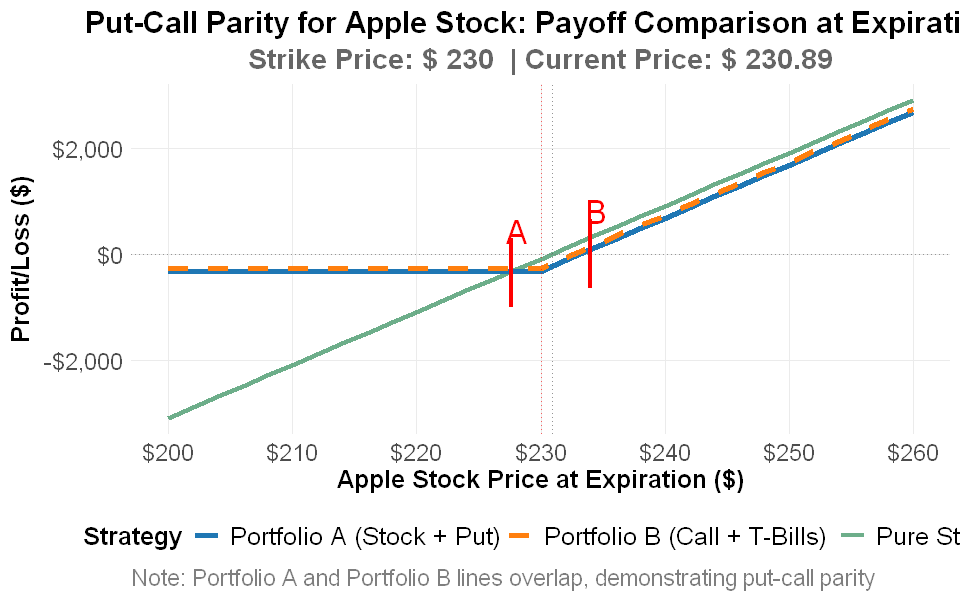

In [47]:
main_plot
ggsave("put_call_parity.png", plot=main_plot,height = 10, width=16)

In [48]:
min_stock = min(payoff_data['stock_price'])
min_stock_profit = min(payoff_data['pure_stock_profit'])

# Define the vertices of the triangle
triangle_data <- data.frame(
  x = c(min_stock, min_stock, current_stock_price), # x coordinates, closing the polygon by repeating the first point
  y = c(min_stock_profit, 0, 0),  # y coordinates
  group = 1             # Group variable for a single triangle
)

In [49]:
# Portfolio A breakdown
portfolio_a_breakdown <- ggplot(payoff_data, aes(x = stock_price)) +
  geom_polygon_pattern(data = triangle_data, aes(x = x, y = y, group = group), 
               fill = "skyblue", 
               color = "black",
               pattern = "stripe",           # Pattern type
               pattern_fill = "skyblue",       # Pattern color
               pattern_color = "red",      # Pattern line color
               pattern_spacing = 0.025,
               pattern_density = 0.025,
               pattern_angle = 135,       # Vertical stripes
               alpha = 0.5) +  # Add triangle first
  geom_area(aes(y = (stock_price - current_stock_price) * shares), 
            fill = "#1f77b4", alpha = 0.3, color = "#1f77b4") +
  geom_area(aes(y = put_payoff), fill = "#5fc86c", alpha = 0.5, color = "#5fc86c") +
  geom_hline(yintercept = 0, color = "gray50", linetype = "dotted", linewidth = 1.2, alpha = 0.8) +
  geom_vline(xintercept = strike_price, color = "red", linetype = "dotted", linewidth = 1.2, alpha = 0.8) +
  labs(
    title = "Portfolio A: Stock + Put Protection",
    subtitle = "Blue = Stock Gain/Loss | Green = Put Protection",
    x = "Stock Price ($)",
    y = "Value ($)"
  ) +
  theme_minimal() +
  theme +
  scale_x_continuous(labels = scales::dollar_format()) +
  scale_y_continuous(labels = scales::dollar_format()) +
  # Add a circle
  annotate("point", x = current_price, y = 0, size = 8, shape = 21, 
            color = "red", stroke = 2) +
# Add text label
  annotate("text", x = current_price, y = -800, label = paste("Break-even: $", round(current_stock_price, 2)), 
           size = 7, hjust = 0, color = "red") +
# Basic arrow
  annotate("segment", x = current_price+.20, y = -660, xend = current_price, yend = -180,
           arrow = arrow(length = unit(0.3, "cm")), 
           color = "red", linewidth = 1)


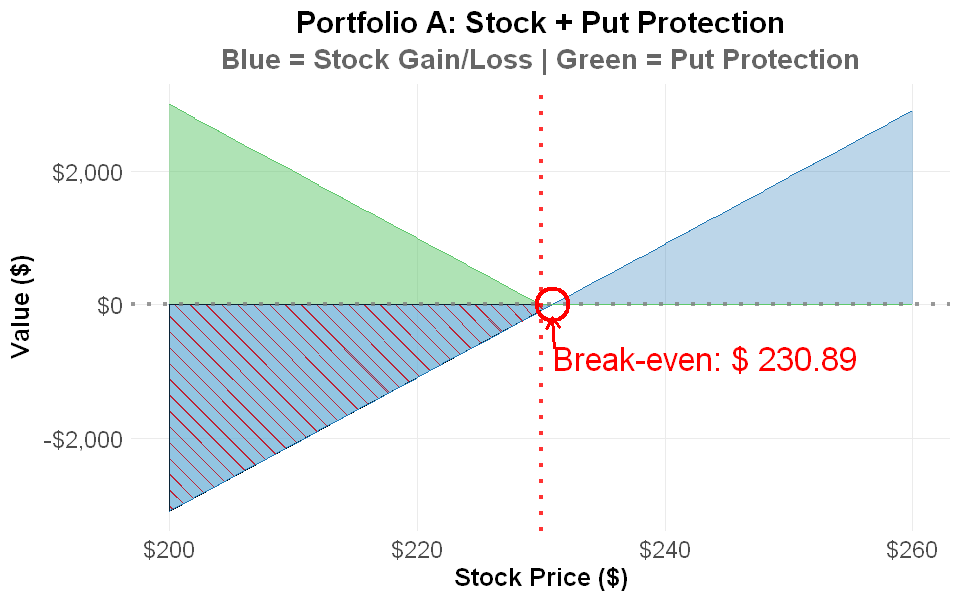

In [50]:
portfolio_a_breakdown
ggsave("portfolio_a_breakdown.png", plot = portfolio_a_breakdown, width=16, height=10)

In [51]:
# Portfolio B breakdown  
portfolio_b_breakdown <- ggplot(payoff_data, aes(x = stock_price)) +
  geom_area(aes(y = call_payoff), fill = "#ff7f0e", alpha = 0.5, color = "#ff7f0e") +
  geom_area(aes(y = (stock_price - current_stock_price) * shares), 
            fill = "#75A9CE", color = "#75A9CE") +
  geom_polygon_pattern(data = triangle_data, aes(x = x, y = y, group = group), 
                fill = "skyblue", 
                color = "black",
                pattern = "stripe",           # Pattern type
                pattern_fill = "skyblue",       # Pattern color
                pattern_color = "red",      # Pattern line color
                pattern_spacing = 0.025,
                pattern_density = 0.025,
                pattern_angle = 135,       # Vertical stripes
                alpha = 0.5) +  # Add triangle first          
  geom_hline(yintercept = 0, color = "gray50", linetype = "dotted") +
  geom_vline(xintercept = strike_price, color = "red", linetype = "dotted", linewidth = 1.2, alpha = 0.8) +
  labs(
    title = "Portfolio B: Call + Treasury Bills",
    subtitle = "Orange = Call Upside | Blue = Stock Gain/Loss",
    x = "Stock Price ($)",
    y = "Value ($)"
  ) +
  theme_minimal() +
  theme +
  scale_x_continuous(labels = scales::dollar_format()) +
  scale_y_continuous(breaks = c(-3000, -2000, -1000, 0 , 1000, 2000, 3000), 
                      limits = c(-3200, 3200),
                      labels = scales::dollar_format())


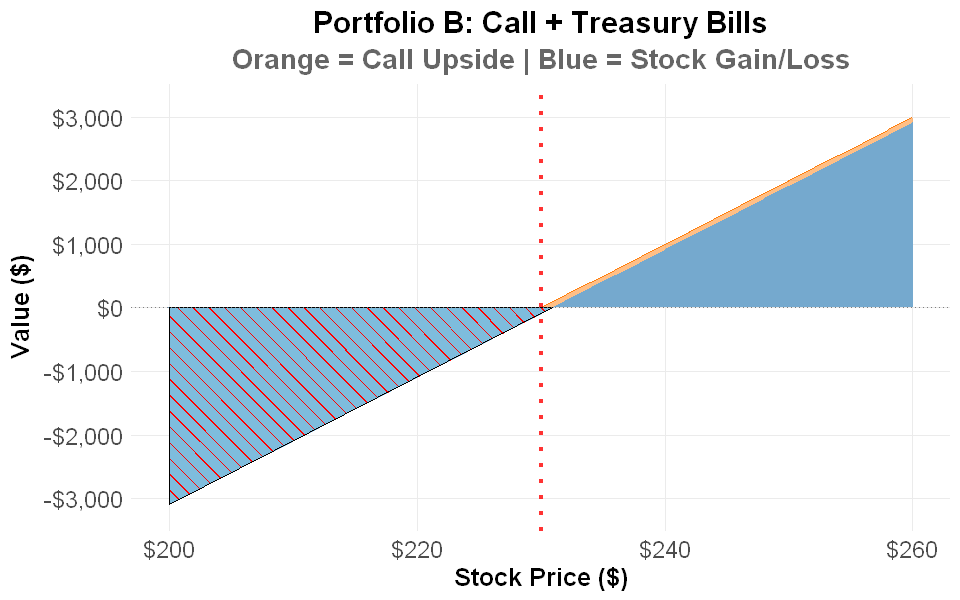

In [52]:
portfolio_b_breakdown
ggsave("portfolio_b_breakdown.png", plot = portfolio_b_breakdown, width=16, height=10)

In [53]:
# Calculate key statistics for interpretation
protection_cost <- (put_price * shares)
max_loss_pure_stock <- min(payoff_data$pure_stock_profit)
max_loss_protected <- min(payoff_data$portfolio_a_profit)
break_even_price <- current_stock_price + put_price

# Print key insights
cat("\n=== KEY INSIGHTS FROM PAYOFF DIAGRAMS ===\n")
cat("Protection Cost (Put Premium):", scales::dollar(protection_cost), "\n")
cat("Maximum Loss - Pure Stock:", scales::dollar(max_loss_pure_stock), "\n") 
cat("Maximum Loss - Protected Position:", scales::dollar(max_loss_protected), "\n")
cat("Break-even Price (Stock + Put):", scales::dollar(break_even_price), "\n")
cat("Current Stock Price:", scales::dollar(current_stock_price), "\n")
cat("Strike Price:", scales::dollar(strike_price), "\n")

# Portfolio cost comparison
portfolio_a_cost <- current_stock_price * shares + put_price * shares
portfolio_b_cost <- call_price * shares + strike_price * shares

cat("\n=== PORTFOLIO COST COMPARISON ===\n")
cat("Portfolio A Total Cost:", scales::dollar(portfolio_a_cost), "\n")
cat("Portfolio B Total Cost:", scales::dollar(portfolio_b_cost), "\n")
cat("Cost Difference:", scales::dollar(abs(portfolio_a_cost - portfolio_b_cost)), "\n")

# Verify put-call parity at specific points
verification_prices <- c(220, 230, 240, 250)
cat("\n=== PUT-CALL PARITY VERIFICATION ===\n")
cat("Stock Price | Portfolio A Value | Portfolio B Value | Difference\n")
cat("-----------|------------------|------------------|----------\n")

for(price in verification_prices) {
  a_value <- price * shares + max(strike_price - price, 0) * shares
  b_value <- max(price - strike_price, 0) * shares + strike_price * shares
  difference <- abs(a_value - b_value)
  cat(sprintf("$%-10.0f | $%-15.0f | $%-15.0f | $%.2f\n", 
              price, a_value, b_value, difference))
}


=== KEY INSIGHTS FROM PAYOFF DIAGRAMS ===
Protection Cost (Put Premium): $224.00 
Maximum Loss - Pure Stock: -$3,089.00 
Maximum Loss - Protected Position: -$313.00 
Break-even Price (Stock + Put): $233.13 
Current Stock Price: $230.89 
Strike Price: $230 

=== PORTFOLIO COST COMPARISON ===
Portfolio A Total Cost: $23,313.00 
Portfolio B Total Cost: $23,261 
Cost Difference: $52.00 

=== PUT-CALL PARITY VERIFICATION ===
Stock Price | Portfolio A Value | Portfolio B Value | Difference
-----------|------------------|------------------|----------
$220        | $23000           | $23000           | $0.00
$230        | $23000           | $23000           | $0.00
$240        | $24000           | $24000           | $0.00
$250        | $25000           | $25000           | $0.00


## Historical "What-If" Analysis

#### Calculate and Structure Data Table

In [54]:
# Calculate monthly price points (or whatever frequency you prefer)
monthly_prices <- historical_prices[endpoints(historical_prices, on = "months")]
monthly_prices <- as.numeric(Cl(monthly_prices))

In [55]:
# Calculate what each strategy would have returned
results <- data.frame(
  date = as.Date(index(monthly_data)),  # This should now give actual dates
  stock_price = as.numeric(Cl(monthly_data))
) %>%
  mutate(
    # Pure stock returns
    pure_stock_return = (stock_price - current_stock_price) * shares,
    
    # Portfolio A: Stock + Put (protection kicks in below strike)
    portfolio_a_value = stock_price * shares + pmax(strike_price - stock_price, 0) * shares,
    portfolio_a_return = portfolio_a_value - (current_stock_price * shares + put_premium),
    
    # Portfolio B: Call + T-bills  
    portfolio_b_value = pmax(stock_price - strike_price, 0) * shares + strike_price * shares,
    portfolio_b_return = portfolio_b_value - (call_premium + strike_price * shares)
  )

In [56]:
# Visualize the comparison
what_if_plot <- ggplot(results, aes(x = date)) +
  geom_line(aes(y = pure_stock_return, color = "Pure Stock"), linewidth = 1.1) +
  geom_line(aes(y = portfolio_a_return, color = "Portfolio A"), linewidth = 1.1) +
  geom_line(aes(y = portfolio_b_return, color = "Portfolio B"), linewidth = 1.1) +
  labs(title = "Historical Performance: Protected vs Unprotected Strategies",
       y = "Cumulative Return ($)",
       x = "Date") +
  theme_minimal() +
  theme +
  scale_y_continuous(breaks = c(-3000, -2000, -1000, 0 , 1000, 2000, 3000), 
                      limits = c(-3200, 3200),
                      labels = scales::dollar_format())

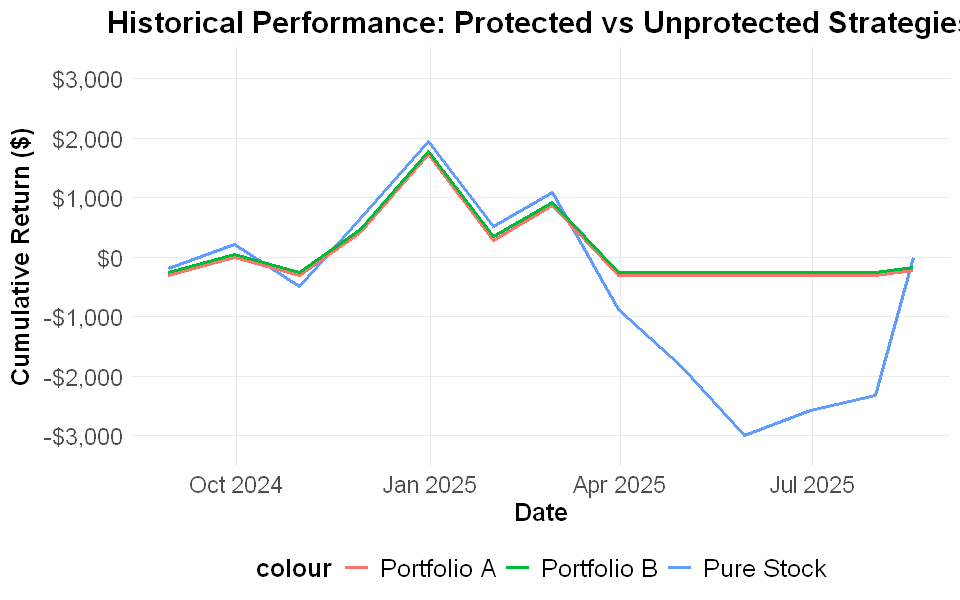

In [57]:
what_if_plot
ggsave("what-if.png", plot=what_if_plot, width=16, height=10)